### Q1 PCA (linear DR) vs t-SNE (non linear DR)

### Importing the required libraries

In [5]:
import pandas as pd
from scipy.io import arff
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the `.arff` dataset file and converting it to a dataframe

In [9]:
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])

### **Bike Sharing Dataset — Attribute Description**

| **Feature** | **Description** | **Type / Values** |
|--------------|----------------|------------------|
| `season` | Season of the year | 1: Spring • 2: Summer • 3: Fall • 4: Winter |
| `year` | Year indicator | 0: 2011 • 1: 2012 |
| `month` | Month number | 1 → 12 |
| `hour` | Hour of the day | 0 → 23 |
| `holiday` | Whether the day is a holiday | 0: No • 1: Yes |
| `weekday` | Day of the week | 0 → 6 (Sunday → Saturday) |
| `workingday` | Indicates if the day is a working day (not weekend/holiday) | 0: No • 1: Yes |
| `weather` | Weather condition | 1: Clear / Few Clouds / Partly Cloudy  <br> 2: Mist / Cloudy / Broken Clouds  <br> 3: Light Snow / Light Rain / Scattered Clouds  <br> 4: Heavy Rain / Ice Pellets / Snow + Fog |
| `temp` | Normalized temperature in °C | Divided by 41 (max) |
| `feel_temp` | Normalized “feeling” temperature in °C | Divided by 50 (max) |
| `humidity` | Normalized humidity | Divided by 100 (max) |
| `windspeed` | Normalized wind speed | Divided by 67 (max) |
| `casual` | Count of casual users | Integer |
| `registered` | Count of registered users | Integer |
| `count` | **Total rental bikes (casual + registered)** | Integer |

The dataset contains some binary string columns which we need to preprocess in order to further progress in our analysis.

In [10]:
df

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,casual,registered,count
0,b'spring',0.0,1.0,0.0,b'False',6.0,b'False',b'clear',9.84,14.395,0.81,0.0000,3.0,13.0,16.0
1,b'spring',0.0,1.0,1.0,b'False',6.0,b'False',b'clear',9.02,13.635,0.80,0.0000,8.0,32.0,40.0
2,b'spring',0.0,1.0,2.0,b'False',6.0,b'False',b'clear',9.02,13.635,0.80,0.0000,5.0,27.0,32.0
3,b'spring',0.0,1.0,3.0,b'False',6.0,b'False',b'clear',9.84,14.395,0.75,0.0000,3.0,10.0,13.0
4,b'spring',0.0,1.0,4.0,b'False',6.0,b'False',b'clear',9.84,14.395,0.75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,b'spring',1.0,12.0,19.0,b'False',1.0,b'True',b'misty',10.66,12.880,0.60,11.0014,11.0,108.0,119.0
17375,b'spring',1.0,12.0,20.0,b'False',1.0,b'True',b'misty',10.66,12.880,0.60,11.0014,8.0,81.0,89.0
17376,b'spring',1.0,12.0,21.0,b'False',1.0,b'True',b'clear',10.66,12.880,0.60,11.0014,7.0,83.0,90.0
17377,b'spring',1.0,12.0,22.0,b'False',1.0,b'True',b'clear',10.66,13.635,0.56,8.9981,13.0,48.0,61.0


### Cleaning the dataset by fixing the byte string columns

In [11]:
# If there are byte string columns, decode them to regular strings
for column in df.select_dtypes([object]).columns:
    df[column] = df[column].str.decode('utf-8')

### Dividing between features and labels

In [12]:
X = df.drop(columns=['count', 'casual', 'registered'])
y = df['count']

### We need numerical features and no string based features so that we can use them in PCA and TSNE as both methods work on distance calculation.

In [13]:
X_encoded = pd.get_dummies(X)

- The box plot shows significant scale disparity among features e.g. year is near 0, while windspeed exceeds 50 which confirms the need for preprocessing.
- Standardization  is crucial to ensure all features contribute equally to the dimensionality reduction.
- Unscaled data would lead to features with high variance like temp, windspeed dominating the calculation of principal components and t-SNE embeddings.



<Axes: >

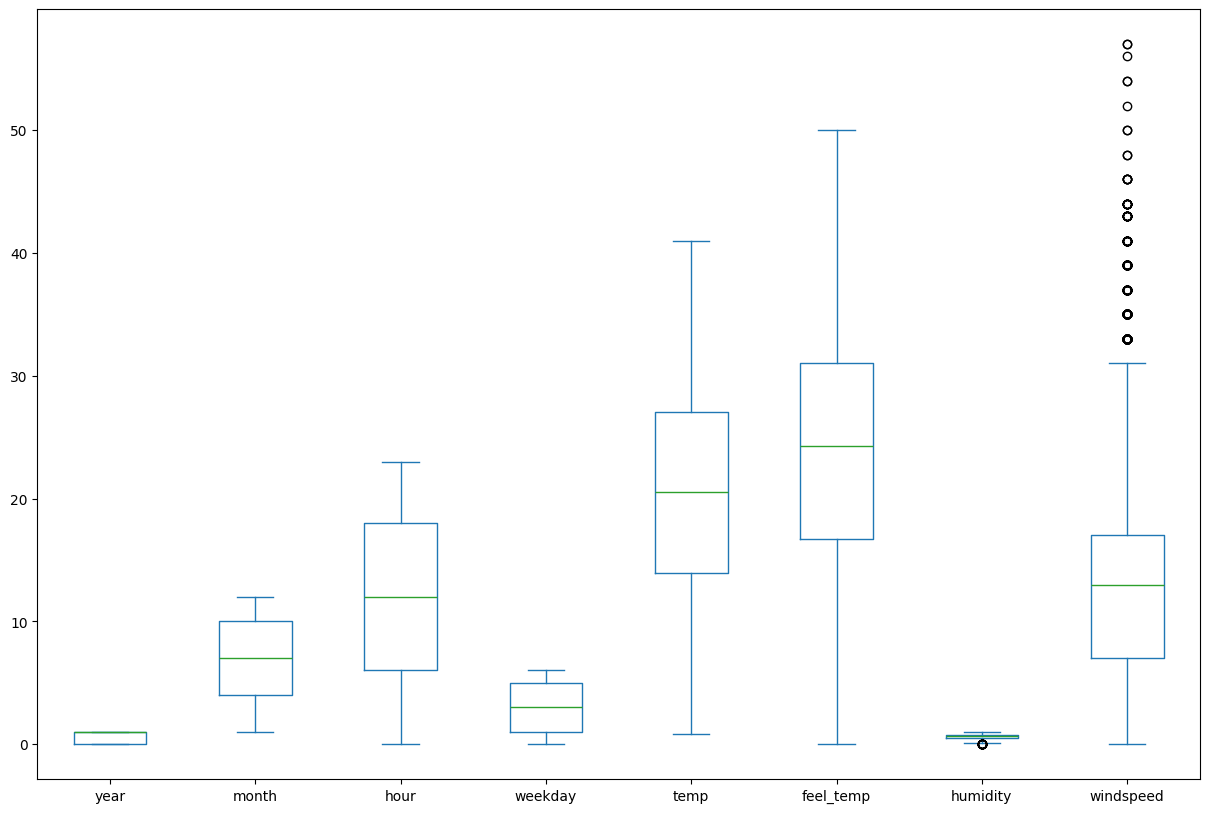

In [14]:
X_encoded.plot(kind='box', figsize=(15,10))

We will be using standardizing the data so that it has mean of 0 and std of 1

In [15]:
X_scaled = StandardScaler().fit_transform(X_encoded)

After applying standardization the data appears well scaled with all features now centered around zero and having comparable variance, making them suitable for PCA and t-SNE.

<Axes: >

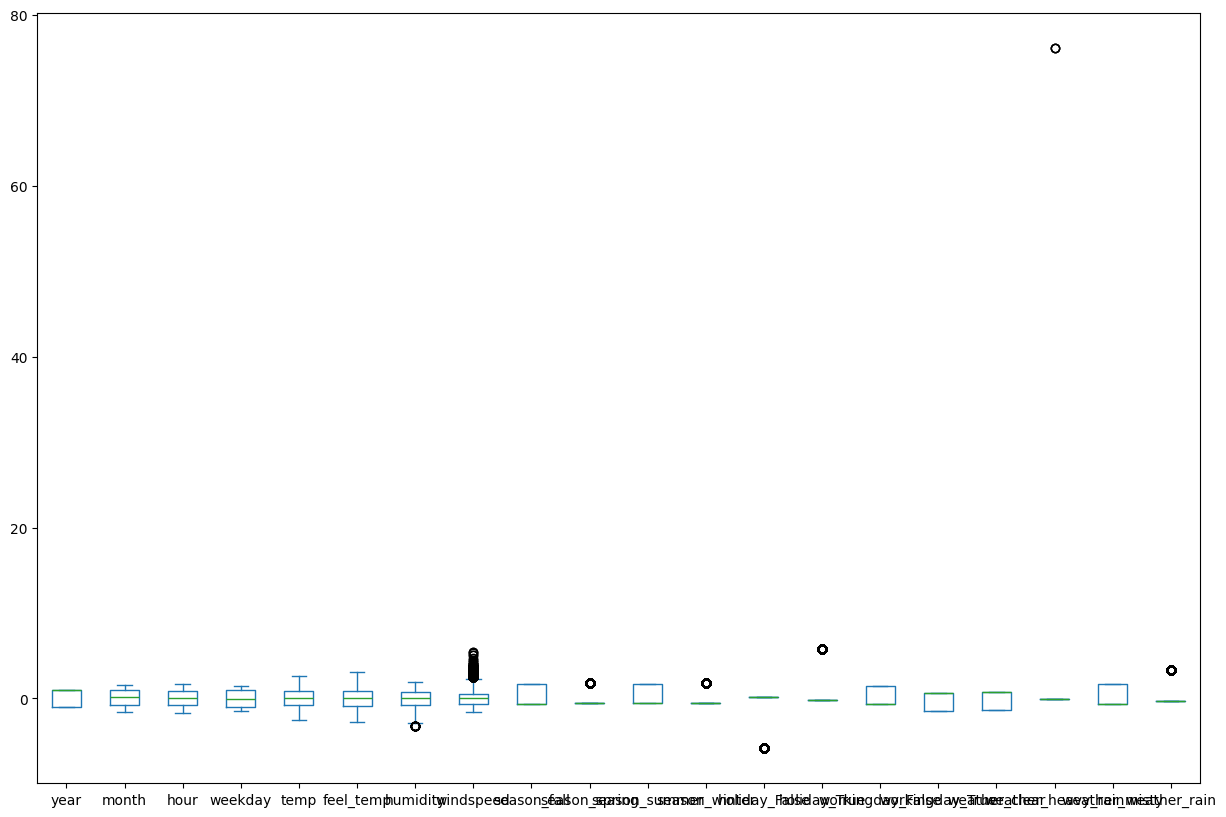

In [16]:
pd.DataFrame(X_scaled, columns=X_encoded.columns).plot(kind='box', figsize=(15,10))

- Linear technique that maximizes the global variance in the data. The resulting plot will show the overall structure and spread of the data.
- Features with the highest variance (after scaling) contribute most to the first principal component.

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

- Non linear technique designed to preserve local structures (i.e., clustering). It is generally better for visualizing tight clusters than PCA.

- (perplexity=30) Sets a crucial hyperparameter (usually between 5 and 50) that can be conceptually thought of as the number of effective nearest neighbors. This value determines the balance between focusing on local (small perplexity) vs. global (large perplexity) aspects of the data structure.

- (random_state=42) Ensures the model's random initialization is the same every time to guarantee reproducible results t-SNE is a stochastic algorithm, so a fixed random state is essential for consistent outputs.

In [18]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

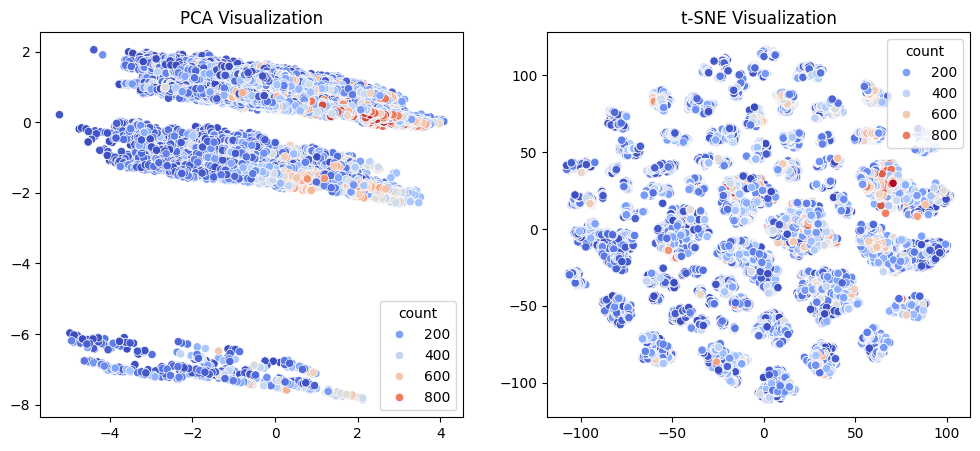

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm')
plt.title("PCA Visualization")

plt.subplot(1,2,2)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='coolwarm')
plt.title("t-SNE Visualization")
plt.show()

- The data points form elongated linear clusters which suggests that PCA captured mostly global variance but missed nonlinear relationships
- t-SNE reveals well defined clusters and each blob represents points that are locally similar in terms of features like temperature, humidity, working day, and season

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))

R²: 0.22520905823164794
RMSE: 24534.073870855555


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))

R²: 0.5935141110816764
RMSE: 12871.542875063971


| Method | $R^2$ | RMSE |
| -      | - | - |
| PCA | 0.2252 | 24534.07 |
| t-SNE | 0.5935 | 12871.54 |

- PCA compresses global variance but loses nonlinear relationships
- t-SNE preserves local clusters which results in model accuracy
- t-SNE is less practical for deployment since it is computationaly expensive as compared to PCA

---

### Q2 Visualize MNIST-784 with SOM

In [11]:
from minisom import MiniSom
from sklearn.datasets import fetch_openml
import numpy as np

- Used the fetch_openml to get the MNIST_784 dataset rather than downloading the `.arff` files
- Creating the feature and label metrics

In [12]:
# 28*28 = 784
mnist = fetch_openml('mnist_784', version=1)
X_mnist = mnist.data.values
y_mnist = mnist.target.astype(int)

The pixel values, which originally ranged from 0 to 255, were divided by 255.0. This min-max scaling step normalizes all features to a common range of 0 to 1, which is necessary for:
- Ensuring all pixel features contribute equally to distance calculations (critical for distance-based algorithms like SOM).
- Improving the performance and convergence speed of iterative machine learning models.

In [13]:
X_scaled = X_mnist / 255.0

A 36x36 grid of neurons was initialized by using the calculation `SQRT(70000) * 5 = 1322` This size (1,296 total nodes) was selected to provide sufficient resolution to visually separate and cluster the 10 distinct digit classes present in the MNIST data.

Training Parameters: The SOM was trained over 10,000 iterations using:
- An initial learning rate (ALPHA) of 0.5 and a standard deviation (SIGMA0) of 1.0.
- The asymptotic_decay function was applied to both parameters to ensure stable convergence and fine tuning over the training period.
- The weight vectors of the map were randomly initialized using a distribution based on the input data (X_scaled), which helps the training process start from a relevant initial state.

In [40]:
SOM_X_AXIS_NODES  = 36
SOM_Y_AXIS_NODES  = 36
SOM_N_VARIABLES  = X_scaled.shape[1]

SIGMA0 = 1.0
ALPHA = 0.5
DECAY_FUNC = 'asymptotic_decay'
NEIGHBORHOOD_FUNC = 'gaussian'
TOPOLOGY = 'rectangular'
DISTANCE_FUNC = 'euclidean'
RANDOM_SEED = 123
SIGMA_DECAY_FUNC = 'asymptotic_decay'

som = MiniSom(
        SOM_X_AXIS_NODES,
        SOM_Y_AXIS_NODES,
        SOM_N_VARIABLES,
        sigma=SIGMA0,
        learning_rate=ALPHA,
        neighborhood_function=NEIGHBORHOOD_FUNC,
        activation_distance=DISTANCE_FUNC,
        topology=TOPOLOGY,
        sigma_decay_function = SIGMA_DECAY_FUNC,
        decay_function = DECAY_FUNC,
        random_seed=RANDOM_SEED,
        )

som.random_weights_init(X_scaled)

N_ITERATIONS = 10000
som.train_random(X_scaled, N_ITERATIONS, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 4.669509061721909


U-Matrix helps visualizes the distances between neighboring neurons on the SOM grid. This matrix provides insight into the inherent structure of the MNIST dataset:
- Dark areas (lower distance values) represent clusters of similar neurons. These are the valleys in the data manifold, indicating areas where the SOM successfully grouped similar digits.

- Light areas (higher distance values) represent large distances between neighboring neurons. These are the boundaries or mountains that separate distinct, well defined clusters (the different digit classes).

The matrix shows clear dark patches separated by lighter ridge like structures. This indicates that the SOM successfully organized the 784 dimensional pixel data into well separated clusters, suggesting a high degree of separability between the different digit types.

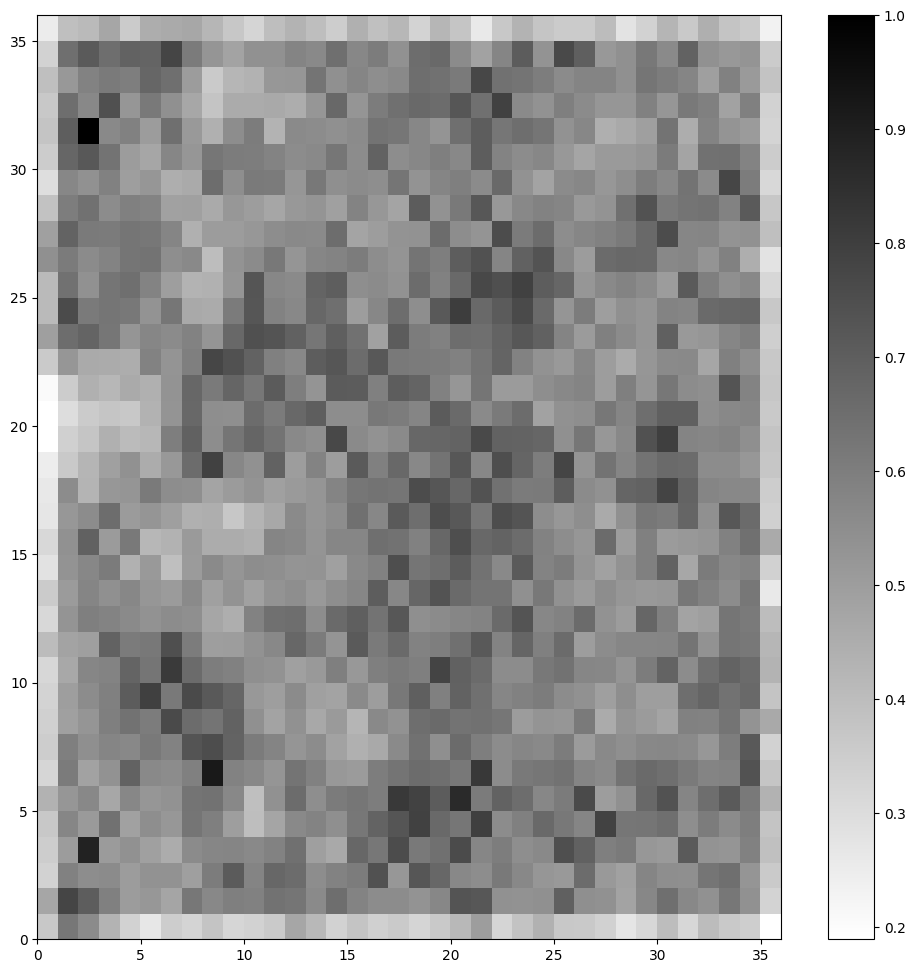

In [41]:
# create the grid
plt.figure(figsize=(12, 12))
#plot the distance map
plt.pcolor(som.distance_map().T, cmap='gist_yarg') 
# show the color bar
plt.colorbar()
plt.show()

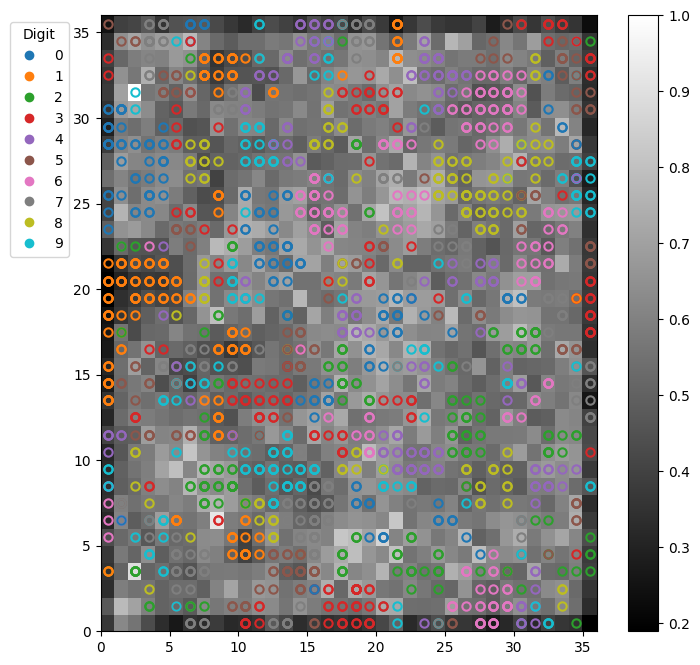

In [ ]:
import matplotlib.lines as mlines
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='gray')  # U-matrix
plt.colorbar()

# pick one marker, 10 distinct colors (one per class)
colors = plt.cm.tab10(np.arange(10))  # 10 distinct colors

for i, datapoint in enumerate(X_scaled[:10000]):
    w = som.winner(datapoint)
    plt.plot(w[0]+0.5, w[1]+0.5, 'o',
             markerfacecolor='None',
             markeredgecolor=colors[y_mnist[i]],
             markersize=6, markeredgewidth=1.5)


# --- Add legend ---
handles = [
    mlines.Line2D([], [], color=colors[d], marker='o', linestyle='None',
                  markersize=6, label=str(d))
    for d in range(10)
]
plt.legend(handles=handles, title="Digit", bbox_to_anchor=(-0.05, 1), loc='upper right')

plt.show()

Hit Map (or Label Map) which assigns the actual digit label (0-9) to the Best Matching Unit (BMU) on the SOM grid. This map directly validates the U-Matrix results:

- The map shows that most neurons (grid cells) are dominated by hits from a single color (digit). For instance, large, contiguous regions are purely red (Digit '4') or green (Digit '8').

- The distinct patches of single colors confirm that the dark areas (valleys) observed in the U-Matrix correspond precisely to the distinct digit classes. The map demonstrates excellent organization, with the 10 digit classes forming large, well isolated clusters.

- Areas where colors mix e.g. between the clusters for '3' and '5', or '7' and '9' often correspond to the lighter boundary regions in the U-Matrix. This overlap indicates ambiguous input samples where the visual features are similar making it difficult for the SOM to perfectly separate them, reflecting a common challenge in handwritten digit recognition.

/var/folders/r0/j25s34097z3202qp_htcbmc80000gn/T/ipykernel_63751/165186858.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.3,


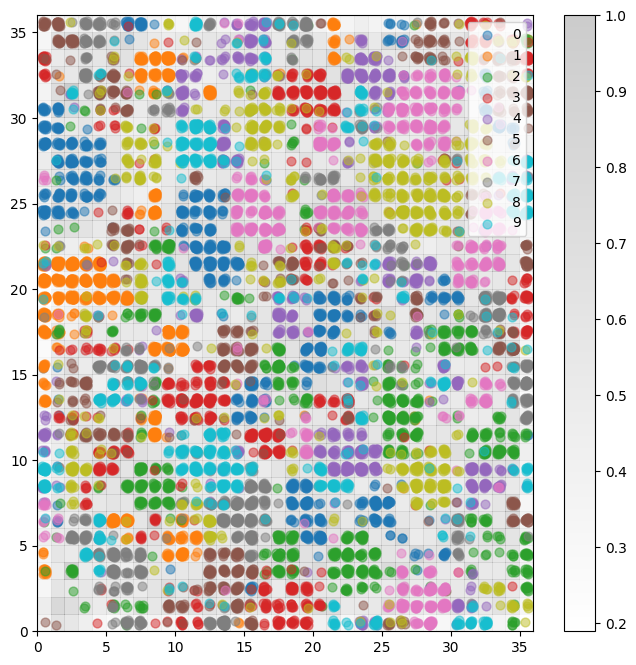

In [57]:
labels_mnist = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9'}

# randomly sample 10,000 indices
sample_idx = np.random.choice(len(X_scaled), 10000, replace=False)

# subset both data and labels
X_sample = X_scaled[sample_idx]
y_sample = y_mnist[sample_idx]

# get the X and Y coordinates of the winning neuron for each data point
w_x, w_y = zip(*[som.winner(d) for d in X_sample])
w_x = np.array(w_x)
w_y = np.array(w_y)
# plot the distance map
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='gist_yarg', alpha=.2)
plt.colorbar()
# make a scatter plot of all the winning neurons for each data point
# add a random offset to each point to avoid overlaps
for c in np.unique(y_sample):
    idx_target = y_sample==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.3,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.3,
                s=40, 
                c=colors[c], 
                label=labels_mnist[c],
                alpha=0.5
                )
plt.legend(loc='upper right')
plt.grid(False)
plt.show()